# QUANTIZATION - OVERVIEW

## Quantization

* What it achieves:
  * Models are **4x smaller size**
  * **1.5 - 4x** faster compute, lower power consumption
  * Allows execution on specialized FP accelerators (Edge CPUs, TPUs, DSP)

* How it works
  * Reduce static parameter (weights) from **high precision to lower precision** (e.g. Float32 --> Float16)
  * Executes operations between the static parameters and dynamic inputs, activation in lower precision
  * Possible to run entire model computation in lower fixed point precision

## Uniform/Linear quantization

* WITHOUT QUANTIZATION
  * TF Model --> tf.lite --> tflite model

* WITH QUANTIZATION
  * TF model --> tf.lite with quantization --> tflite model (More model compression & size)


In [1]:
!nvidia-smi

Thu Oct 24 23:26:59 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.107.02             Driver Version: 550.107.02     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:01:00.0 Off |                  Off |
|  0%   36C    P8             15W /  450W |      12MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)
import tensorflow as tf
from tensorflow.keras import layers,models
import numpy as np
import matplotlib.pyplot as plt

#Load MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

# Define the model architecture
model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28)),
  tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
  tf.keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10)
])

# Train the digit classification model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])
model.fit(
  train_images,
  train_labels,
  epochs=5,
  validation_data=(test_images, test_labels)
)
    

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8658 - loss: 0.4876 - val_accuracy: 0.9638 - val_loss: 0.1249
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9689 - loss: 0.1138 - val_accuracy: 0.9749 - val_loss: 0.0812
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9781 - loss: 0.0784 - val_accuracy: 0.9779 - val_loss: 0.0705
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9807 - loss: 0.0680 - val_accuracy: 0.9800 - val_loss: 0.0642
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9835 - loss: 0.0562 - val_accuracy: 0.9804 - val_loss: 0.0587


#### Convert to a Tensorflow Lite model - No quantization

In [4]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmps3w2ufem/assets


INFO:tensorflow:Assets written to: /tmp/tmps3w2ufem/assets


Saved artifact at '/tmp/tmps3w2ufem'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='keras_tensor_6')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  129941081825600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129941082287872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129941082285056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129941082282768: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1729792653.718877    5946 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1729792653.718886    5946 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2024-10-24 23:27:33.719075: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmps3w2ufem
2024-10-24 23:27:33.719264: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-10-24 23:27:33.719268: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmps3w2ufem
2024-10-24 23:27:33.720798: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-10-24 23:27:33.721062: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-10-24 23:27:33.732167: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmps3w2ufem
2024-10-24 23:27:33.735274: I tensorflow/cc/saved_model/loader.cc

#### Convert to a Tensorflow Lite model - Integer only quantization

In [5]:
#Range of the values the model will encounter --> Uses TF dataset created from training images, batching them into single samples & taking 100 samples
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
    yield [input_value]

#TF lite converter initialization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
#Initialize weight quantization to reduce ther model size and improve inference speed
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
#INT8 quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
#converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_FLOAT16]
#converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
#Convert TFlite model
tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp5pfyza3n/assets


INFO:tensorflow:Assets written to: /tmp/tmp5pfyza3n/assets


Saved artifact at '/tmp/tmp5pfyza3n'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='keras_tensor_6')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  129941081825600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129941082287872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129941082285056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129941082282768: TensorSpec(shape=(), dtype=tf.resource, name=None)


/home/gk/.local/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1729792657.106164    5946 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1729792657.106172    5946 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2024-10-24 23:27:37.106260: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp5pfyza3n
2024-10-24 23:27:37.106460: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-10-24 23:27:37.106464: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp5pfyza3n
2024-10-24 23:27:37.107908: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-10-24 23:27:37.117166: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp5pfyza3n

In [6]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


#### Save the TF Lite models

In [7]:

import pathlib
tflite_models_dir = pathlib.Path("./mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)
# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"mnist_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

24800

#### Run the TF Lite models

TF interpreter: Interface for running TF Lite models

In [8]:

# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
  global test_images

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    test_image = test_images[test_image_index]
    test_label = test_labels[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()

  return predictions


#### Test the models on one image

* tflite_model file: Original TF lite model with floating point data
* tflite_model_quant file: Integer only quantization (it uses uint8 data for input & output)

In [9]:
# Change this to test a different image
test_image_index = 1

## Helper function to test the models on one image
def test_model(tflite_file, test_image_index, model_type):
  global test_labels

  predictions = run_tflite_model(tflite_file, [test_image_index])

  plt.imshow(test_images[test_image_index])
  template = model_type + " Model \n True:{true}, Predicted:{predict}"
  _ = plt.title(template.format(true= str(test_labels[test_image_index]), predict=str(predictions[0])))
  plt.grid(False)
     

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


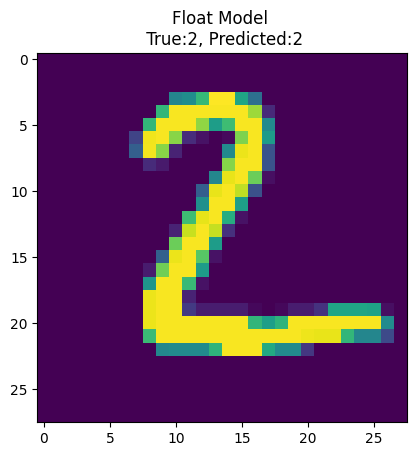

In [10]:
test_model(tflite_model_file, test_image_index, model_type="Float")

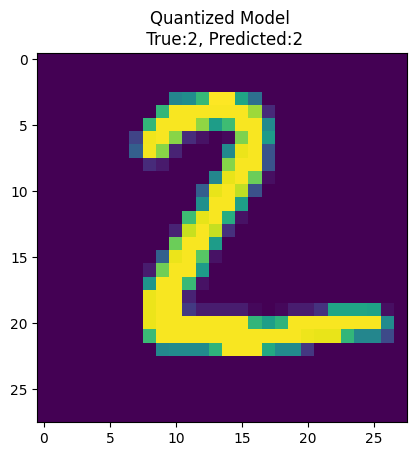

In [11]:
test_model(tflite_model_quant_file, test_image_index, model_type="Quantized")

#### Evaluate the models on all images

In [12]:
# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type):
  global test_images
  global test_labels

  test_image_indices = range(test_images.shape[0])
  predictions = run_tflite_model(tflite_file, test_image_indices)

  accuracy = (np.sum(test_labels== predictions) * 100) / len(test_images)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(test_images)))

In [13]:
evaluate_model(tflite_model_file, model_type="Float")

Float model accuracy is 98.0400% (Number of test samples=10000)


In [14]:
evaluate_model(tflite_model_quant_file, model_type="Quantized")

Quantized model accuracy is 98.0100% (Number of test samples=10000)


### Summary - Uniform/Linear Quantization
* Quantization executes models in lower precision and is a lossy process
* Leads to drop in accuracy of the model : Fast (But inaccurate model is not helpful)
* Has amazing benefits for users / performance ==> So we need to get best of both

## QUANTIZATION AWARE TRAINING (QAT)

**TF model --> Quantized model --> Fine-tuned quantized model --> TFlite model**

### What is it??
* Training time technique for improving the accuracy of quantized models
* Introduces inference time quantization errors during training so model runs robust parameters around it

### How QAT recover lost accuracy??
* Make the training path as similar as possible to the inference path **(FP32 --> INT8 --> FP32)**
* Mimic the errors experienced by the model during inference in training

    * **Mimiking errors, aka Fake Quant**
       * Quantize to lower precision, then convert back to float (Introduces the quantize error)
       * Both inputs & weights quantized, hence computation exactly mimics the int8 (float values are at the boundary of lower precision)
    * **Modelling inferencing path**
       * Inference optimizations may fuse ReLU activations or fold batch norm to conv layers
       * QAT applies the same transformations to training & adjust fake quant insertions accordingly.

In [16]:
#Load MNIST dataset
from tensorflow_model_optimization.python.core.keras.compat import keras

mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

# Define the model architecture
model =keras.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28)),
  keras.layers.Reshape(target_shape=(28, 28, 1)),
  keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(10)
])
print(model.summary())
# Train the digit classification model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])
model.fit(
  train_images,
  train_labels,
  epochs=5,
  validation_data=(test_images, test_labels)
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 12)        120       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 12)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 2028)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                20290     
                                                                 
Total params: 20410 (79.73 KB)
Trainable params: 20410 (79.73 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

* Quantization aware training to the whole model. All layers are prefixed by "quant"

In [17]:
import tensorflow_model_optimization as tfmot
quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

q_aware_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLa  (None, 28, 28)            3         
 yer)                                                            
                                                                 
 quant_reshape_1 (QuantizeW  (None, 28, 28, 1)         1         
 rapperV2)                                                       
                                                                 
 quant_conv2d_1 (QuantizeWr  (None, 26, 26, 12)        147       
 apperV2)                                                        
                                                                 
 quant_max_pooling2d_1 (Qua  (None, 13, 13, 12)        1         
 ntizeWrapperV2)                                                 
                                                                 
 quant_flatten_1 (QuantizeW  (None, 2028)             

In [24]:
train_images_subset = train_images[0:1000] # out of 60000
train_labels_subset = train_labels[0:1000]

q_aware_model.fit(train_images_subset, train_labels_subset,
                  batch_size=500, epochs=1, validation_split=0.1)
     

2/2 [==============================] - 0s 30ms/step - loss: 0.0616 - accuracy: 0.9822 - val_loss: 0.0543 - val_accuracy: 0.9800


In [25]:
_, baseline_model_accuracy = model.evaluate(
    test_images, test_labels, verbose=0)

_, q_aware_model_accuracy = q_aware_model.evaluate(
   test_images, test_labels, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)
print('Quant test accuracy:', q_aware_model_accuracy)

Baseline test accuracy: 0.9776999950408936
Quant test accuracy: 0.9800999760627747


In [26]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp46o88yx8/assets


INFO:tensorflow:Assets written to: /tmp/tmp46o88yx8/assets
/home/gk/.local/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1729792747.742634    5946 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1729792747.742642    5946 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2024-10-24 23:29:07.742730: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp46o88yx8
2024-10-24 23:29:07.743725: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-10-24 23:29:07.743732: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp46o88yx8
2024-10-24 23:29:07.749330: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-10-24 23:29:07.773719: I tensorflow/cc/saved_model/loader.cc:220] Running initi

In [27]:
import numpy as np

def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for i, test_image in enumerate(test_images):
    if i % 1000 == 0:
      print('Evaluated on {n} results so far.'.format(n=i))
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  print('\n')
  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_digits)
  accuracy = (prediction_digits == test_labels).mean()
  return accuracy

In [28]:

interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
interpreter.allocate_tensors()

test_accuracy = evaluate_model(interpreter)

print('Quant TFLite test_accuracy:', test_accuracy)
print('Quant TF test accuracy:', q_aware_model_accuracy)

Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.


Quant TFLite test_accuracy: 0.9801
Quant TF test accuracy: 0.9800999760627747


### 4x smaller model from quantization

In [30]:
# Create float TFLite model.
import tempfile
import os
float_converter = tf.lite.TFLiteConverter.from_keras_model(model)
float_tflite_model = float_converter.convert()

# Measure sizes of models.
_, float_file = tempfile.mkstemp('.tflite')
_, quant_file = tempfile.mkstemp('.tflite')

with open(quant_file, 'wb') as f:
  f.write(quantized_tflite_model)

with open(float_file, 'wb') as f:
  f.write(float_tflite_model)

print("Float model in Mb:", os.path.getsize(float_file) / float(2**20))
print("Quantized model in Mb:", os.path.getsize(quant_file) / float(2**20))

INFO:tensorflow:Assets written to: /tmp/tmpzms9p7ci/assets


INFO:tensorflow:Assets written to: /tmp/tmpzms9p7ci/assets


Float model in Mb: 0.08073043823242188
Quantized model in Mb: 0.02367401123046875


W0000 00:00:1729792759.097387    5946 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1729792759.097395    5946 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2024-10-24 23:29:19.097478: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpzms9p7ci
2024-10-24 23:29:19.097938: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-10-24 23:29:19.097944: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpzms9p7ci
2024-10-24 23:29:19.100598: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-10-24 23:29:19.114999: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpzms9p7ci
2024-10-24 23:29:19.119000: I tensorflow/cc/saved_model/loader.cc:462] SavedModel load for tags { serve }; Status: success: OK. Took 21524 microseconds.
